In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u

# Testing global configuration:

In [3]:
from nyx.core import config_summary, set_healpix_nside, config_context, get_wavelengths, get_healpix_nside, get_grid_dim

In [4]:
set_healpix_nside(2**4)
config_summary()

NYX Global Configuration
wavelengths                   : array(shape=(50,), dtype=float32)
                                (Wavelength grid in nm)
healpix_nside                 : 16
                                (HEALPix nside parameter)
use_hemisphere                : True
                                (Whether to use only upper hemisphere)
airmass_formula               : kasten_young_1989
                                (Airmass calculation formula)
grid_dim                      : 2
                                (Image interpolation grid dimension)
use_jit                       : True
                                (Whether to use JAX JIT compilation)
precision                     : float32
                                (Numerical precision for calculations)
spectral_method               : conserve
                                (Spectral interpolation method)
                                (Warn when spectral resolution is degraded)
gradient_checkpointing        : False
 

# Testing spectral interpolation:

In [5]:
from nyx.core import SpectralHandler

In [6]:
from nyx import ASSETS_PATH
ag_array = np.genfromtxt(ASSETS_PATH+'eso_skycalc_airglow_130sfu.dat')
wl_high = jnp.array(ag_array[:,0].flatten())
flux_high = jnp.array(ag_array[:,1].flatten())

In [7]:
results = {}
methods = ['linear', 'conserve']
for method in methods:
    with config_context(spectral_method=method, spectral_resolution_warning=False, wavelengths=jnp.linspace(320,700,30)):
        wl_low = get_wavelengths()
        flux_low = SpectralHandler.resample(wl_high, flux_high, wl_low)
        results[method] = flux_low
        
        # Calculate total flux
        mask = (wl_high>=jnp.min(wl_low))&(wl_high<=jnp.max(wl_low))
        total_in = jnp.trapezoid(flux_high[mask], wl_high[mask])
        total_out = jnp.trapezoid(flux_low, wl_low)
        conservation = total_out / total_in
        
        print(f"\n  {method.upper()} method:")
        print(f"    Flux conservation: {conservation:.1%}")
        print(f"    Peak preservation: {flux_low.max() / flux_high.max():.1%}")



  LINEAR method:
    Flux conservation: 82.7%
    Peak preservation: 0.0%

  CONSERVE method:
    Flux conservation: 99.7%
    Peak preservation: 0.0%


# Testing observation implementation:

In [8]:
import astropy
from astropy.coordinates import SkyCoord
from nyx.core import Observation

In [9]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2025-09-28T18:30:16', format='isot', scale='utc')
target   = SkyCoord.from_name('Vul OB1')
obs = Observation(location, obstime, target, rotation, fov=3*u.deg)

In [10]:
with config_context(grid_dim=4):
    print(obs.get_eval_coordinates(altaz=True))

<SkyCoord (AltAz: obstime=2025-09-28T18:30:16.000, location=(5622.333422015386, 1665.7099041749266, -2505.2121403078927) km, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [[(349.29156204, 39.05751066), (351.86346506, 39.12608186),
      (354.43826714, 39.13441211), (357.01142425, 39.08246992)],
     [(349.1606214 , 41.05499868), (351.81232798, 41.12569972),
      (354.46727153, 41.13428921), (357.12037829, 41.08073234)],
     [(349.02147675, 43.05232921), (351.75797504, 43.12529355),
      (354.49810074, 43.13415859), (357.236168  , 43.07888569)],
     [(348.87296048, 45.04947982), (351.69994721, 45.12485992),
      (354.53101534, 45.13401912), (357.35976727, 45.07691443)]]>


# Testing atmosphere implementation:

In [11]:
from nyx.atmosphere import atmospheres

In [12]:
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        hg_asymmetry=0.75
        )

In [13]:
%%time
atmo_gen, atmo_par = atmo.get_generator(obs)

CPU times: user 44.4 ms, sys: 1.96 ms, total: 46.4 ms
Wall time: 45.3 ms


In [14]:
%%time
params = {k:atmo_par[k].initial_value*0.95 for k in atmo_par}
res = atmo_gen(params)

CPU times: user 470 ms, sys: 12.8 ms, total: 483 ms
Wall time: 449 ms


# Testing instrument implementation:

In [15]:
from nyx.instrument import instruments

In [16]:
from nsb2.instrument import HESS
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

In [17]:
%%time
inst_gen, inst_par = HESS1.get_generator(obs)

CPU times: user 88.1 ms, sys: 11.9 ms, total: 100 ms
Wall time: 96.4 ms


In [18]:
%%time
params = {k:inst_par[k].initial_value for k in inst_par}
res_inst = inst_gen(params)

CPU times: user 111 ms, sys: 9.29 ms, total: 121 ms
Wall time: 122 ms


# Testing zodiacal light implementation:

In [19]:
from nyx.emitter import zodiacal
leinert = zodiacal.Leinert1998()

In [20]:
%%time
zod_gen, zod_par, zod_type = leinert.get_generator(obs)

CPU times: user 20.5 ms, sys: 3.04 ms, total: 23.6 ms
Wall time: 22.3 ms


In [21]:
%%time
params = {k:zod_par[k].initial_value for k in zod_par}
res = zod_gen(params)

CPU times: user 252 μs, sys: 34 μs, total: 286 μs
Wall time: 237 μs


# Testing airglow implementation:

In [22]:
from nyx.emitter import airglow
glow = airglow.ESOSkyCalc()

In [23]:
%%time
glow_gen, glow_par, glow_type = glow.get_generator(obs)

CPU times: user 512 ms, sys: 29.7 ms, total: 542 ms
Wall time: 453 ms


In [24]:
%%time
params = {k:glow_par[k].initial_value for k in glow_par}
res = glow_gen(params)

CPU times: user 168 ms, sys: 8.71 ms, total: 177 ms
Wall time: 173 ms


# Testing moonlight implementation:

In [25]:
from nyx.emitter import moon
jones = moon.Jones2013()

In [26]:
%%time
moon_gen, moon_par, moon_type = jones.get_generator(obs)

CPU times: user 639 ms, sys: 28.2 ms, total: 667 ms
Wall time: 541 ms


In [27]:
%%time
params = {k:moon_par[k].initial_value for k in moon_par}
res = moon_gen(params)

CPU times: user 0 ns, sys: 558 μs, total: 558 μs
Wall time: 326 μs


In [28]:
from nyx import ASSETS_PATH
from nyx.utils.spectra import SolarSpectrumRieke2008

import jax.numpy as jnp
import numpy as np
import healpy as hp
import astropy
import astropy.units as u
from astropy.constants import c, h
from scipy.interpolate import UnivariateSpline

In [29]:
from nyx.units import nixify

wavelengths = get_wavelengths()

wvl, spectrum = SolarSpectrumRieke2008()
flx = nixify(spectrum*u.arcsec**2, 'flux', wavelength=wavelengths)

# Testing catalog implementation:

# Testing model implementation:

In [30]:
from nyx.core.model import Model

In [31]:
pipeline = Model(HESS1, atmo, [jones])
scene = pipeline.query(obs)

In [32]:
initial_params = scene.get_initial_parameters()

In [33]:
print("\nInitial Parameters:")
scene.print_parameters(format='table')


Initial Parameters:
┌─────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter     │ Shape  │ Initial │ Current │ Bounds │ Description             │ 
├─────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ obs_height_km │ (1,)   │ 0.0000  │ -       │ -      │ Observatory height [km] │ 
│ atmosphere │ atmosphere │ aod_500       │ (1,)   │ 0.1000  │ -       │ -      │ AOD at 500nm            │ 
│ atmosphere │ atmosphere │ angstrom_exp  │ (1,)   │ 1.0000  │ -       │ -      │ Angstrom exponent       │ 
│ atmosphere │ atmosphere │ hg_asymmetry  │ (1,)   │ 0.7500  │ -       │ (0, 1) │ HG asymmetry            │ 
│ instrument │ instrument │ shift         │ (2,)   │ -       │ -       │ -      │ Pixel shift in rad      │ 
│ instrument │ instrument │ flatfield     │ (960,) │ -       │ -       │ -      │ Flatfielding values     │ 


# Testing scene rendering:

In [34]:
from nyx.core.integrator import render

In [35]:
scene_instance = scene.realize(initial_params)
img = render(scene_instance)

# Visualize data

In [36]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('HESS-I')
def ctapipe_disp(cam, rates, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = rates
    display.add_colorbar(label=label)
    return display

/usr/local/lib/python3.13/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


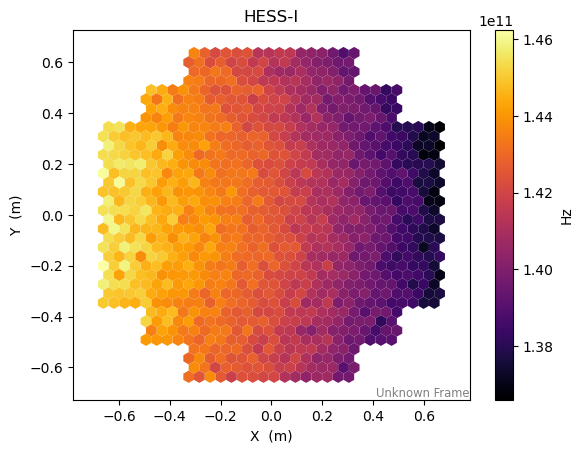

In [41]:
fig, ax = plt.subplots()
disp = ctapipe_disp(cam, img, ax, label='Hz')

In [38]:
(1*u.sr / (1*u.arcsec**2)).to(u.dimensionless_unscaled)

<Quantity 4.25451703e+10>

In [39]:
(4.2374e-10 * u.sr).to(u.arcsec**2)

<Quantity 18.02809046 arcsec2>